In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
from meshmaker.vec3 import vec3
from meshmaker.quat import quat
from meshmaker.tform import tform
#from meshmaker.field import scalar_field, vec3_field
from meshmaker.mesh import planargraph, trimesh
from meshmaker.geometry import slide, bbox, subdivide_triangles, loop_normal, loop_exterior, loop_split, loop_smooth, loop_contract, loop_area, periodic, isnear
from meshmaker.lsystem import lsystem
from meshmaker.img import perlin, proximal, normalize, segment_regions, steepness
from meshmaker.plt import plot, plot_pg, plot_loop, plot_edges, plot_edge, plot_point
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from functools import partial, reduce

In [9]:
import cv2


class field:
    """"""

    @staticmethod
    def decay(decay, weight):
        return lambda o, r: o * (weight * np.exp(-decay * r ** 2))
    

    @staticmethod
    def zero():
        raise NotImplementedError


    def __new__(cls, methods):
        def f(p):
            q = cls.zero()
            for m in methods:
                q = q + m(p)
            return q
        return f


class scalar_field(field):
    """"""

    @classmethod
    def zero(cls):
        return 0


    @classmethod
    def radial(cls, q, z, decay=0.0, weight=1.0):
        decay = cls.decay(decay, weight)
        def eigen(p):
            return decay(z, p.dxy(q))
        return eigen

    
    @classmethod
    def edges(cls, loop, z, decay, weight):
        decay = cls.decay(decay, weight)
        def eigen(p):
            o = 0.0
            for u, v in slide(loop, 2):
                o += decay(z, p.dexy(u, v))
            return o
        return eigen

    
    @classmethod
    def edge(cls, u, v, z, decay, weight):
        decay = cls.decay(decay, weight)
        def eigen(p):
            return decay(z, p.dexy(u, v))
        return eigen
    
    
    @classmethod
    def topography(cls, img, tf, weight):        
        def eigen(p):            
            local = tf.transform(p)
            x = min(img.shape[1] - 1, int(local.x))
            y = min(img.shape[0] - 1, int(local.y))
            z = img[y, x]
            return z * weight
        return eigen


class image_field(scalar_field):
    """"""

    def __new__(cls, tf, img):
        es = (scalar_field.topography(img, tf, 1.0), )
        fd = super().__new__(cls, es)
        fd.img = img
        fd.tf = tf
        return fd


class height_field(image_field):
    """"""
    
    def __new__(cls, origin, radius, resolution, landmasses):
        pixels = int(2 * radius * resolution)
        tf = cls.wtoi(origin, radius, pixels)
        n = perlin(pixels, 16 * 8, 8, 4)    
        f = lambda d: max(0, d) ** 0.8
        p = sum([proximal(pixels, tf.transform(lm), f) for lm in landmasses])
        p = normalize(p)
        height = n * p
        for j in range(20):
            height = cv2.blur(height, (8, 8))
        return super().__new__(cls, tf, height)

    @staticmethod
    def wtoi(origin, radius, resolution):
        dp = origin.tov(vec3(resolution / 2, resolution / 2, 0))
        ds = vec3(resolution / (2 * radius), resolution / (2 * radius), 1)
        tf = tform(dp, None, ds)
        return tf


class vec3_field(field):
    """"""

    @staticmethod
    def zero():
        return vec3.O()


    @classmethod
    def radial(cls, q, decay, weight):
        decay = cls.decay(decay, weight)
        def eigen(p):
            return decay((p - q).nrm(), p.dxy(q))
        return eigen

    
    @classmethod
    def edge(cls, u, v, decay, weight):
        decay = cls.decay(decay, weight)
        tangent = (v - u).nrm()
        normal = tangent.crs(vec3.Z()).nrm()
        def eigen(p):
            isleft = ((u.x - p.x) * (v.y - p.y) - (v.x - p.x) * (u.y - p.y))
            return decay(normal * (1 if isleft else -1), p.dexy(u, v))
            #return decay(tangent, p.dexy(u, v)) 
        return eigen

    
    @classmethod
    def grid(cls, q, major, decay, weight):
        decay = cls.decay(decay, weight)
        def eigen(p):
            return decay(major, p.dxy(q))
        return eigen

    
    @classmethod
    def topography(cls, terrain, weight):
        dx, dy = np.gradient(terrain.img)
        dx = image_field(terrain.tf, dx)
        dy = image_field(terrain.tf, dy)
        def eigen(p):
            dpdx = dx(p)
            dpdy = dy(p)
            return vec3(dpdx, dpdy, 0) * weight * max(1, np.sqrt(dpdx ** 2 + dpdy ** 2))
        return eigen


class trace_field(vec3_field):
    """"""
    
    def __new__(cls, methods, ds=1, alpha=0):
        fd = super().__new__(cls, methods)
        def f(p):
            """trace a sequence of new edges using fields"""
            while True:
                q = p + (fd(p).nrm() * ds).rot(quat.av(alpha, vec3.Z()))
                yield q
                p = q
        return f

In [4]:
def plot_vec3_field(ax, fd):
    ps = []
    for x in np.linspace(-500, 500, 21):
        for y in np.linspace(-500, 500, 21):
            ps.append(vec3(x, y, 0))
    a, b = bbox(ps)
    dl = max(b.x - a.x, b.y - a.y) / 100
    for p in ps:
        v = fd(p)
        v.nrmd()
        u = v.crs(vec3.Z())
        u.nrmd()
        plot_point(ax, p)
        plot_edge(ax, p - v * (dl / 1), p + v * (dl / 1), lw=2, col='b')
        plot_edge(ax, p - u * (dl / 1), p + u * (dl / 1), lw=1, col='g')
    _ = 300
    ax.set_xlim((-_, _))
    ax.set_ylim((-_, _))
    return ax

In [5]:
def percentile_mask(a, n=5):
    """set all but the n highest values in a to 0"""
    q = n * 100 / len(a)
    q = min(max(q, 100), 0)
    a[np.where(a < np.percentile(a, q))] = 0
    return a


def distribution(a, n_best=None):
    """get a useful distribution for sampling from a"""
    if n_best is not None:
        a = percentile_mask(a, n=n_best)
    if a.max() == 0:
        a += 1
    a /= a.sum()
    return a

In [6]:
class proceduralgraph(planargraph):    
    """a planar graph which can be procedural grown"""

    def __init__(self, fd, *ags, layer=0, **kws):
        super().__init__(*ags, **kws)
        self.fd = fd
        self.layer = layer
    

    @property
    def elements(self):
        """get vec3_field elements which may depend on self"""
        return [self.fd]

    
    def fork_field(self, decay=0.01, weight=1.0, min_order=4):
        """get scalar_field based on vertex path distances to forked intersections"""
        rad = partial(scalar_field.radial, decay=decay, weight=weight)
        es = ((v, self.forkorder(i)) for i, v in enumerate(self.vertices) if v is not None)
        return scalar_field([rad(v, o) for v, o in es if o >= min_order])
        
    
    def get_vertex_weights(self, fd, n_best=None, mask=None):
        """get a probability distribution over self.vertices for selection"""
        remask = lambda v: v is None or (mask is not None and mask(v))
        weights = [(0.0 if remask(v) else fd(v)) for v in self.vertices]
        return distribution(np.array(weights), n_best=n_best)


    def get_vertex_alpha(self, eb, p):
        """select alpha value where field points most toward vec3.com(eb)"""
        f = vec3_field(self.elements)(p).nrm()
        c = vec3.com(eb)
        best = None
        chosen = 0
        for alpha in (x * (np.pi / 2) for x in range(4)):
            q = p + f.cp().rot(quat.av(alpha, vec3.Z()))
            d = q.dxy(c)
            if best is None or d < best:
                chosen = alpha
                best = d
        return chosen
    
    
    def find_exit(self, eb, decay=0.01, weight=1.0, min_order=4):
        """find optimal existing vertex on eb"""
        mask = (lambda p: not p.onbxy(eb, True))
        field = self.fork_field(decay, weight, min_order)
        weights = self.get_vertex_weights(field, n_best=5, mask=mask)
        return np.random.choice(len(weights), p=weights)
    

    def find_tip(self, eb=None, decay=0.01, weight=1.0, min_order=4):
        """find optimal existing vertex optional inside or on eb"""
        mask = None if eb is None else (lambda p: not p.inbxy(eb, True))
        field = self.fork_field(decay, weight, min_order)
        weights = self.get_vertex_weights(field, n_best=5, mask=mask)
        return np.random.choice(len(weights), p=weights)
    

    def fork_tips(self, eb=None):
        """yield a sequence of new tips suitable for tracing"""
        s = self.find_tip(eb=eb)
        edges = [((s, o) if (s < o) else (o, s)) for o in self.rings[s]]
        edges = [self.edges[self.edge_lookup[e]] for e in edges]
        alphas = [p['alpha'] for i, j, p in edges]
        if len(alphas) == 0:
            yield (s, 0)
        elif len(alphas) == 1:
            # TODO: assert alpha which does not force u-turn
            yield (s, alphas[0])
        elif len(alphas) == 2:
            a = abs(alphas[1] - alphas[0])
            if isnear(a, 0) or isnear(a, np.pi):
                b = periodic(0, 2 * np.pi, alphas[0] + np.random.choice((1, 3)) * (np.pi / 2))
                yield (s, b)
                if np.random.random() < 0.5:
                    yield (s, periodic(0, 2 * np.pi, b + np.pi))
            else:
                # TODO: assert alpha which does not force u-turn
                yield (s, np.random.choice(alphas))
        elif len(alphas) == 3:
            # TODO: assert alpha which does not force u-turn
            yield (s, sorted(alphas, key=lambda a: alphas.count(a))[0])
        else:
            print('too many alphas!', alphas)

    
    def trace(self, u, dl, alpha=0, break_check=None, n=20):
        """trace a sequence of new edges using fields"""
        ds = dl / n
        p = self.vertices[u]        
        for i, q in enumerate(trace_field(self.elements, ds, alpha)(p)):
            if break_check and break_check(q):
                return
            v = self.av(q, e=(0.9 * ds), layer=self.layer)
            if v == u:
                return
            self.ae(u, v, alpha=alpha, layer=self.layer)
            if not v == len(self.vertices) - 1:
                return
            u = v
            if i == n - 1:
                break
        return u
    
        
    def inset(self, eb, ibs, dl, tips=None, max_steps=50, fork_prob=0.2, max_depth=3, depth=0):
        """recursively generate a denser graph within eb but outside of ibs"""
        oob = lambda p: not p.inbxy(eb, False) or any(p.inbxy(ib, True) for ib in ibs)

        if tips is None:
            tips = [(self.av(vec3.com(eb)), np.random.choice(4) * (np.pi / 2))]
        else:
            tips = [(self.av(p.cp()), self.get_vertex_alpha(eb, p)) for p in tips]
        
        steps = 0
        with tqdm(total=max_steps, desc='insetting roads') as pbar:
            while tips and steps < max_steps:
                tip, alpha = tips.pop(0)
                newtip = self.trace(tip, dl, alpha, oob, 20)
                if newtip is not None:
                    tips.append((newtip, alpha))
                if np.random.random() < fork_prob or not tips:
                    for newtip in self.fork_tips(eb=eb):
                        tips.append(newtip)
                steps += 1
                pbar.update(1)
        
        if depth < max_depth - 1:
            loops = [[self.vertices[u] for u in l] for l in self.loops()]
            eloop = loops.pop(loop_exterior(loops))        
            for iloop in loops:
                tip = self.find_exit(iloop)
                tips = [(tip, self.get_vertex_alpha(iloop, self.vertices[tip]))]
                self.layer += 1
                self.inset(iloop, ibs, tips, dl, max_steps, fork_prob, max_depth, depth + 1)
                self.layer -= 1  

In [7]:
class shorelinegraph(proceduralgraph):
    """"""
    
    def __init__(self, fd, eb, ibs, *ags,
                 tips=None, max_steps=50, fork_prob=0.2, max_depth=2, **kws):
        super().__init__(fd, *ags, **kws)

        if tips is None:
            tips = [(self.av(vec3.com(eb)), np.random.choice(4) * (np.pi / 2))]
        else:
            tips = [(self.av(p.cp()), self.get_vertex_alpha(eb, p)) for p in tips]

        p, q = bbox(eb)
        dl = (q - p).mag() / 10
        dl *= 2

        self.inset(eb, ibs, tips, dl, max_steps, fork_prob, max_depth)

In [ ]:
class roadgraph(proceduralgraph):

    @classmethod
    def bounded(cls, eb, ibs, fd, exits=None, max_steps=50, fork_prob=0.2, max_depth=2):
        """generate graphs within each of ibs; connect within eb; connect to exits if provided
        
        eb -> landmass
        ibs -> urban graphs
        exits -> bridges
        
        use one field to make the rural graph which forces connection between ibs
        use another field for each urban graph
        
        """
        
        
        """generate graph within eb but outside of ibs"""
        pg = cls(fd)
        #pg.fd = fd
        #pg.layer = 0

        # TODO: assert com.inpxy(eb)
        if exits is None:
            tips = [(pg.av(vec3.com(eb)), np.random.choice(4) * (np.pi / 2))]
        else:
            tips = [(pg.av(exit.cp()), pg.get_vertex_alpha(eb, exit)) for exit in exits]

        p, q = bbox(eb)
        dl = (q - p).mag() / 10
        dl *= 2

        pg.inset(eb, ibs, tips, dl, max_steps=max_steps, fork_prob=fork_prob, max_depth=max_depth)

        return pg

In [ ]:
# layer 0 graph paritions all world landmass
    # inner loops define each landmass
    # inner edges define each river

    # create height_field from landmass partition
    # create shoreline polygons from height_field
    # create urban area polygons from height_field
    
    # select set of exits for each urban area
    # select set of exits for each landmass
    #  bridge crossings or landings

    # for each landmass, roadgraph.inset
    #  shoreline -> eb
    #  urban areas -> ibs
    #  bridges, landings, urban exits -> tips

    #  for each urban area, roadgraph.inset

    
# bridges formed by forcing bidir tips from inner loop edges
# bridge tips must connect to each urban region (sufficently flat terrain gradient)

insetting roads:  40%|████      | 4/10 [00:00<00:00, 35.89it/s]

growing the sea


insetting roads: 100%|██████████| 10/10 [00:00<00:00, 17.67it/s]


growing the land
minlen 7.839377789258236


<IPython.core.display.Javascript object>


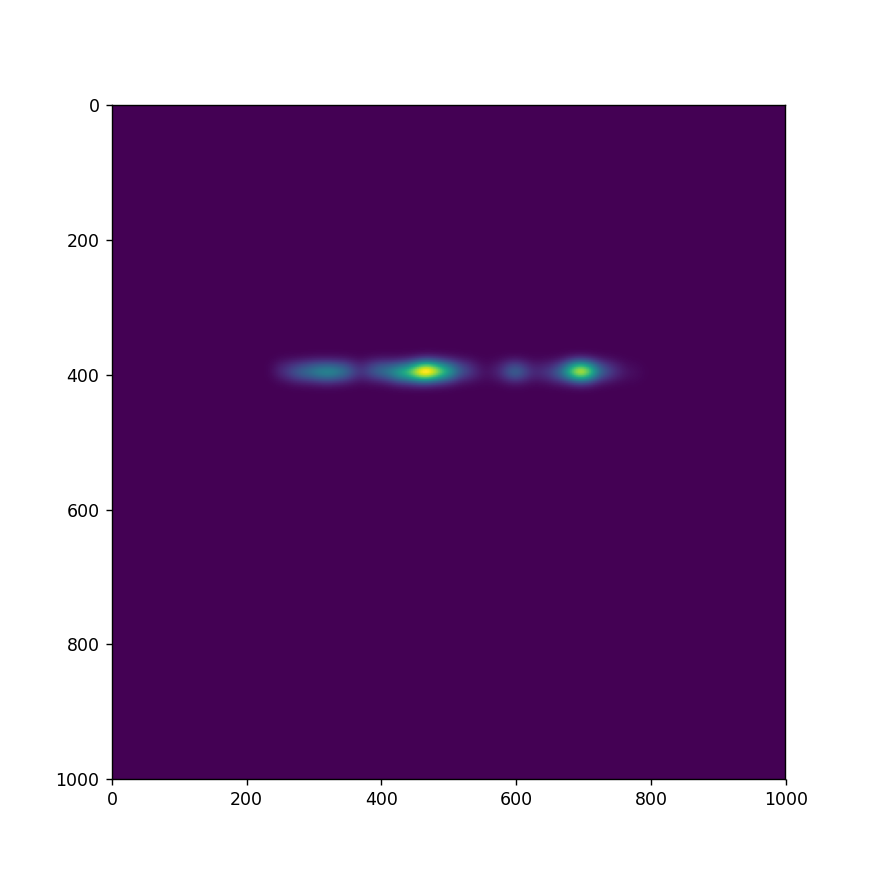

finding the fairway


<IPython.core.display.Javascript object>


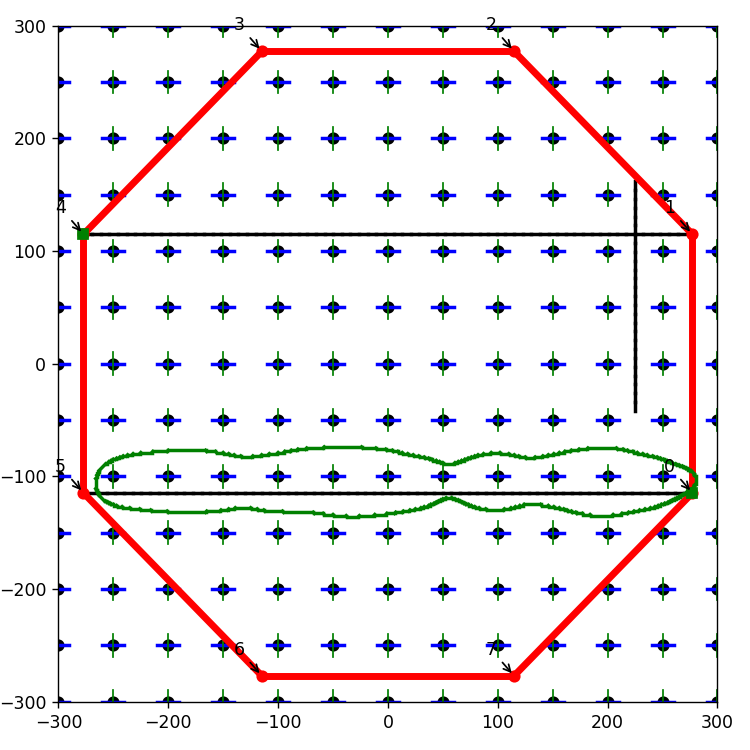

fw [vec3(-266.0000, -111.0000, 0.0000), vec3(-266.0000, -102.0000, 0.0000), vec3(-265.0000, -101.0000, 0.0000), vec3(-265.0000, -99.0000, 0.0000), vec3(-264.0000, -98.0000, 0.0000), vec3(-264.0000, -97.0000, 0.0000), vec3(-263.0000, -96.0000, 0.0000), vec3(-263.0000, -95.0000, 0.0000), vec3(-257.0000, -89.0000, 0.0000), vec3(-256.0000, -89.0000, 0.0000), vec3(-254.0000, -87.0000, 0.0000), vec3(-253.0000, -87.0000, 0.0000), vec3(-252.0000, -86.0000, 0.0000), vec3(-251.0000, -86.0000, 0.0000), vec3(-250.0000, -85.0000, 0.0000), vec3(-248.0000, -85.0000, 0.0000), vec3(-247.0000, -84.0000, 0.0000), vec3(-245.0000, -84.0000, 0.0000), vec3(-244.0000, -83.0000, 0.0000), vec3(-242.0000, -83.0000, 0.0000), vec3(-241.0000, -82.0000, 0.0000), vec3(-238.0000, -82.0000, 0.0000), vec3(-237.0000, -81.0000, 0.0000), vec3(-233.0000, -81.0000, 0.0000), vec3(-232.0000, -80.0000, 0.0000), vec3(-226.0000, -80.0000, 0.0000), vec3(-225.0000, -79.0000, 0.0000), vec3(-215.0000, -79.0000, 0.0000), vec3(-214.000

In [15]:

def test():
    np.random.seed(0)
        
    rim = vec3.O().ring(300, 8)
    holes = ()
    
    p, q = bbox(rim)
    dl = (q - p).mag() / 10
    dl *= 2
    
    tips = [
        rim[0], 
        rim[4],
    ]
    
    elements = [
        vec3_field.grid(vec3(100, 100, 0), vec3.X(), 0.0, 0.00001),
        #vec3_field.radial(vec3.O(), 0.01, 0.01),
        #vec3_field.radial(vec3(100, 300, 0), 0.0001, 0.1),
        #vec3_field.radial(vec3(-300, -100, 0), 0.0001, 0.1),
        #vec3_field.topography(terrain, 0.000001),
    ]
    fd = vec3_field(elements)
    
    pg = proceduralgraph(fd)

    
    print('growing the sea')
    pg.inset(rim, holes, dl, tips=tips, max_steps=10, fork_prob=0.01, max_depth=1)

    
    print('growing the land')
    hmin = 4
    print('minlen', pg.minlen(hmin))
    span = 10
    loops = [[pg.vertices[i] for i in l] for l in pg.loops()]
    loops = sorted(loops, key=lambda l: abs(loop_area(l)), reverse=True)
    loops = [loop_contract(l, span) for l in loops[1:]]
    loops = [loop_split(l, 5 * span) for l in loops]
    loops = [loop_smooth(l, weight=0.5) for l in loops]
    origin = vec3.O()
    radius = 500
    resolution = 1
    terrain = height_field(origin, radius, resolution, loops)
    
    f, ax = plot(figsize=(7, 7))
    ax.imshow(terrain.img)
    plt.show()
    
    
    print('finding the fairway')
    sealevel = 0.02
    sandlevel = 0.04
    z0, dz = terrain.img.min(), terrain.img.max() - terrain.img.min()
    sealevel = z0 + sealevel * dz
    sandlevel = z0 + sandlevel * dz
    fps, lands, regions = segment_regions(terrain.img > sealevel)

    tf = tform(vec3.U().xy() * -radius, None, vec3(2 * radius, 2 * radius, 0))
    fps = [tf.transform(fp) for fp in fps]
    
    '''
    print('finding the green')
    n_cities = 10
    land = sum(lands)
    sand = land & (terrain.img < sandlevel)
    dirt = land & (terrain.img > sandlevel)
    grad = steepness(terrain.img * dirt)
    flat = dirt & (grad < np.percentile(grad[dirt > 0], 10))
    fps, flats, regions = segment_regions(flat)
    fps, flats, regions = zip(*sorted(zip(fps, flat, regions), key=lambda i: i[2].area)[-n_cities:])
    tf = tform(vec3.U().xy() * -radius, None, vec3(2 * radius, 2 * radius, 0))
    fps = [tf.transform(fp) for fp in fps]
    '''
    
    ### CREATE THE TERRAIN FROM PG.LOOPS
    ### CREATE NEW FIELD AND SET FOR PG
    ### CREATE SHORELINE LOOPS
    ### INSET EACH SHORELINE LOOP
    
    
    
    #rg = roadgraph.bounded(rim, holes, fd, tips, max_steps, fork_prob, max_depth)

    '''


    
    
    
    elements = [
        vec3_field.grid(vec3(100, 100, 0), vec3.X(), 0.0, 0.001),
        #(vec3( 100,  200, 0), 0.0002, 0.5),
        #(vec3(-200, -200, 0), 0.001, 0.5),
        #(vec3.O().ring(300, 8), 0.001, 1),
        #(rim, 0.1, 0.1),
        vec3_field.topography(terrain, 0.1),
    ]    
    '''
    
    
    #rg.fd = vec3_field 
    
    f, ax = plot(figsize=(6, 6))
    f.tight_layout()
    
    plot_vec3_field(ax, fd)

    _ = 300
    
    for i, v in enumerate(pg.vertices):
        if v is not None:
            v.properties['annotation'] = str(v.properties.get('layer'))
    
    plot_pg(ax, pg, mk='', lw=2, annotate=False)
    plot_loop(ax, rim, col='r', lw=4, mk='o')
    for fw in fps:
        print('fw', fw)
        plot_loop(ax, fw, col='g', lw=2, mk='')
    for tip in tips:
        plot_point(ax, tip, mk='s', col='g')
    ax.set_xlim((-_, _))
    ax.set_ylim((-_, _))
    
    
#prun test(terrain)
test()

# ##### 

In [ ]:
def fracture(loop, epsilon=20, span=10):
    plant = (
       'X',
        {'X': '-]{{X}[X}[-{[-X}]X', '-': '--'},
        vec3(0, 0, 0),
        vec3(0, 1, 0),
        3,
        25 * (np.pi / 180),
    )        
    segs = lsystem(*plant)

    a, b = bbox(loop)
    c, d = bbox([p for s in segs for p in s])
    dx = (b.x - a.x) / (d.x - c.x)
    dy = (b.y - a.y) / (d.y - c.y)
    ds = vec3(dx, dy, 1)
    dp = (c * ds).tov(a)
    tf = tform(dp, None, ds)
    for j in range(len(segs)):
        segs[j] = tf.transform(segs[j])

    pg = planargraph()
    for i in range(len(loop)):
        pg.ae(loop[i - 1], loop[i], epsilon)
    for u, v in segs:
        pg.ae(u, v, epsilon)

    hmin = 4
    print('minlen', pg.minlen(hmin))
    loops = [[pg.vertices[i] for i in l] for l in pg.loops()]
    loops = sorted(loops, key=lambda l: abs(loop_area(l)), reverse=True)
    loops = [loop_contract(l, span) for l in loops[1:]]
    loops = [loop_split(l, 5 * span) for l in loops]
    loops = [loop_smooth(l, weight=0.5) for l in loops]

    return loops

In [ ]:
import cv2


def dummy_terrain():
    origin = vec3(0, 0, 0)
    radius = 500
    rim = 100
    resolution = 1

    assert(radius > rim)
    boundary = origin.ring(radius, 6)
    pangea = origin.ring(radius - rim, 6)
    shorelines = fracture(pangea)
    terrain = height_field(origin, radius, resolution, shorelines)
    return terrain


terrain = dummy_terrain()

In [ ]:
def map_roads(terrain, dirt, flat, fps):
    elements = []
    #elements.extend([(terrain.tf.transform(fp), 0.0001, 1.0) for fp in fps])
    elements.append((terrain, 0.0, 1.0))
    
    
    fd = vec3_field(elements)

    

    f, ax = plot(figsize=(8, 8))
    ps = []
    for x in np.linspace(0, terrain.img.shape[1], 10):
        for y in np.linspace(0, terrain.img.shape[0], 10):
            ps.append(vec3(x - terrain.img.shape[1] // 2, y - terrain.img.shape[0] // 2, 0))

    
    #fd.plot(ax, ps)
    a, b = bbox(ps)
    dl = max(b.x - a.x, b.y - a.y) / 100
    for p in ps:
        v = fd(p)
        v.nrmd()
        plot_point(ax, p)
        plot_edge(ax, p - v * dl, p + v * dl, lw=1)
    
    
    for e, d, w in elements:
        if isinstance(e, vec3):
            plot_point(ax, e, mk='s', col='r')
        elif isinstance(e, list):
            plot_loop(ax, e, mk='o', col='g', lw=5)
            #plot_edges(ax, e, mk='o', col='g', lw=5)
        elif isinstance(e, scalar_field):
            ax.imshow(e.img, origin='lower', extent=(-500, 500, -500, 500))
        else:
            raise ValueError
    #ax.set_xlim((-600, 600))
    #ax.set_ylim((-600, 600))

In [ ]:
origin = vec3(0, 0, 0)
radius = 500
rim = 100
resolution = 1

assert(radius > rim)
boundary = origin.ring(radius, 6)
pangea = origin.ring(radius - rim, 6)
shorelines = fracture(pangea)
terrain = height_field(origin, radius, resolution, shorelines)



sealevel = 0.02
sandlevel = 0.04
n_cities = 10

z0, dz = terrain.img.min(), terrain.img.max() - terrain.img.min()
sealevel = z0 + sealevel * dz
sandlevel = z0 + sandlevel * dz
fps, lands, regions = segment_regions(terrain.img > sealevel)
land = sum(lands)
sand = land & (terrain.img < sandlevel)
dirt = land & (terrain.img > sandlevel)
grad = steepness(terrain.img * dirt)
flat = dirt & (grad < np.percentile(grad[dirt > 0], 10))
fps, flats, regions = segment_regions(flat)
fps, flats, regions = zip(*sorted(zip(fps, flat, regions), key=lambda i: i[2].area)[-n_cities:])

tf = tform(vec3.U().xy() * -radius, None, vec3(2 * radius, 2 * radius, 0))
fps = [tf.transform(fp) for fp in fps]

roads = map_roads(terrain, dirt, flat, fps)





f, ax = plot()
ax.imshow(terrain.img)

f, ax = plot()
for landmass in shorelines:
    plot_loop(ax, landmass, col='k', mk='')
for fp in fps:
    plot_loop(ax, fp, col='g', mk='')


In [ ]:
def slide(loop, n=1):
    queue = loop[:] + loop[:n]
    while len(queue) > n:
        yield queue[:n]
        queue.pop(0)

In [ ]:
def city(fp, terrain, land, sand, dirt):

    f, ax = plot(figsize=(8, 8))
    #ax.imshow(terrain)
    plot_loop(ax, fp)
    


def civilization(origin, radius, terrain, sealevel=0.02, sandlevel=0.04):
    """Given shorelines, partition space for civilization; modify heightmap accordingly"""
    z0, dz = terrain.min(), terrain.max() - terrain.min()
    
    sealevel = z0 + sealevel * dz
    sandlevel = z0 + sandlevel * dz

    fps, lands, regions = segment_regions(terrain > sealevel)
    land = sum(lands)
    sand = land & (terrain < sandlevel)
    dirt = land & (terrain > sandlevel)
    grad = steepness(terrain * dirt)
    flat = dirt & (grad < np.percentile(grad[dirt > 0], 10))
    fps, flats, regions = segment_regions(flat)
    
    fps, flats, regions = zip(*sorted(zip(fps, flat, regions), key=lambda i: i[2].area)[-5:])
    tf = tform(vec3(0.5, 0.5, 0.5), None, vec3(2 * radius, 2 * radius, 0))
    fps = [tf.transform(fp) for fp in fps]

    for fp in fps:
        city(fp, terrain, land, sand, dirt)
    
    #f, ax = plot(figsize=(8, 8))
    #ax.imshow(terrain)
    #f, ax = plot(figsize=(8, 8))
    #ax.imshow(land)
    #f, ax = plot(figsize=(8, 8))
    #ax.imshow(sand)
    #f, ax = plot(figsize=(8, 8))
    #ax.imshow(dirt)
    #f, ax = plot(figsize=(8, 8))
    #ax.imshow(grad)
    #f, ax = plot(figsize=(8, 8))
    #ax.imshow(flat)
    #for fp in fps:
    #    plot_loop(ax, fp)
    
    return terrain


def test():
    origin, radius, resolution = vec3(0, 0, 0), 500, 1

    pixels = int(2 * radius * resolution)
    deltaz = radius / 4
    
    resolution = pixels

    tf = wtoi(origin, radius, resolution)

    #landmasses = (
    #    vec3(200,-200, 0).ring(100, 4),
    #    vec3(200, 200, 0).ring(100, 4),
    #)
    landmasses = shorelines

    n = perlin(resolution, 16 * 8, 8, 4)
    
    f = lambda d: max(0, d) ** 0.8
    p = sum([proximal(resolution, tf.transform(lm), f) for lm in landmasses])
    p = normalize(p)
    
    height = n * p
    
    #f, ax = plot(figsize=(8, 8))
    #ax.imshow(height)

    civilization(origin, radius, height)
    
test()

In [ ]:

    
    
def heightmap(resolution, delta, origin, radius):
    tf = wtoi(origin, radius, resolution)

    landmasses = shorelines

    n = perlin(resolution, 16 * 8, 8, 4)
    
    f = lambda d: max(0, d) ** 0.8
    p = sum([proximal(resolution, tf.transform(lm), f) for lm in landmasses])
    p = normalize(p)
    
    height = n * p
    
    #height = civilization(height)
    
    height = scalar_field(tf, height)
    return lambda p: vec3(p.x, p.y, delta * height(p))

In [ ]:
def terrain(origin, radius, resolution):
    pixels = int(2 * radius * resolution)
    deltaz = radius / 4
    height = heightmap(pixels, deltaz, origin, radius)
    triangles = origin.fan(radius, 6)
    for i in range(6):
        triangles = subdivide_triangles(triangles)
    mesh = trimesh()
    for u, v, w in triangles:
        mesh.af(height(u), height(v), height(w))
    return mesh

In [ ]:
from meshmaker.obj import obj_world
from meshmaker.model import model

prefix = './'
textures = {
    'default': './resources/textures/orangeboxtex.png',
}
models = (model().add(terrain(vec3(0, 0, 0), 500, 1), 'default'), )
obj_world(prefix, models, textures)

In [ ]:
!ls ./resources/textures/orangeboxtex.png

In [ ]:
!cat ./materials.mtl

In [ ]:
!ls ./ -lavh

In [ ]:
from meshmaker.vec3 import vec3

def slide(loop, n=1):
    queue = loop[:] + loop[:n]
    while len(queue) > n:
        yield queue[:n]
        queue.pop(0)

def test():
    loop = vec3.O().ring(4, 8)
    one = [[loop[i]] for i in range(len(loop))]
    two = [[loop[i - 1], loop[i]] for i in range(len(loop))]
    two.append(two.pop(0))
    three = [[loop[i - 2], loop[i - 1], loop[i]] for i in range(len(loop))]
    three.append(three.pop(0))
    three.append(three.pop(0))
    assert list(slide(loop, 1)) == one
    assert list(slide(loop, 2)) == two
    assert list(slide(loop, 3)) == three
    
test()
        

In [ ]:
from meshmaker.plt import plot, plot_pg, plot_loop


def loop_aggregate(loop, radius, alpha=None):
    assert len(loop) > 3, 'loops require 4+ vertices to aggregate'
    
    edges = [radius < (v - u).mag() for u, v in slide(loop, 2)]
    assert edges.count(True) > 2, 'nothing would be left after aggregate'
    
    piece = []
    newloop = []
    for u, v, w in slide(loop, 3):
        #print((v - u).mag(), (w - v).mag())
        if (v - u).mag() < radius or (w - v).mag() < radius:
            piece.append(v)
        elif alpha and (u - v).saxy(w - v) < alpha:
            piece.append(v)
        #else:
        if piece:
            newloop.append(vec3.com(piece))
            piece = []
        else:
            newloop.append(v)
    return newloop
    
def test():
    
    loop = vec3.O().ring(4, 32)
    reloop = loop_aggregate(loop, 4)
    
    f, ax = plot(figsize=(8, 8))
    plot_loop(ax, loop, col='g', lw=8)
    plot_loop(ax, reloop, col='b')
    
test()

In [ ]:


def loop_diagonals(loop):
    diagonals = {}
    for i in range(len(loop)):
        u = loop[i]
        for j in range(len(loop)):
            #if abs(i - j) > 1:
            if (i - j) > 1:
                v = loop[j]
                diagonals[(i, j)] = (u, v)
    return diagonals


def loop_diagonal_lengths(loop):
    diagonals = loop_diagonals(loop)
    lengths = [(v - u).mag() for u, v in diagonals.values()]
    return lengths



# TRASH 

In [ ]:

            '''
            if steps % 50 == 0 and False:
                for i, v in enumerate(pg.vertices):
                    if v:
                        #v.properties['annotation'] = str(pg.order(i))
                        v.properties['annotation'] = str(v.properties.get('weight'))
                f, ax = plt.subplots(1, 1, figsize=(8, 8))
                f.tight_layout
                plot_pg(ax, pg, mk='', annotate=False)
                plot_vec3_field(ax, pg.field)                    
                plt.show()
            ''' 